# UK Traffic Accident EDA

I was attending a Hackathon in Birmingham in 2017 with some friends and while searching for some open data on data.gov.uk I first came accross this dataset dealing with road accidents in the UK. I was looking for some inspiration to create a cool project for our hackathon entry and did some research on this dataset and all the meta-data available. Though we ended up doing something different for the hackathon, I wanted at some point to come back to this and do an alysis and visualise it.

The UK department for transport provides data for road accidents in the UK. The dataset which contains information about accidents, vehicles and casualties (amongst other variable) goes back to 1979. During my research I found that this dataset was posted on Kaggle where peole have posted their kernels and there are also several posts around the web with their own analyses. This set was also used in on of the /r/dataisbeautiful monthly visualisation challenges. I have borrowed ideas and learned from a lot of these different posts and articles from the web and will list the notable ones which have provided me with ideas and help to learn new things.

This data is 1.6 millions rows of traffic accidents in the UK from 2005 to 2014 with data from 2008 missing. Though this is not really 'Big data', I will first look at reducing memory footprint of importing this data in pandas so that we can use save memory. In a later post I will explore visualising all of the 1.6 million points using Holoviews.  

This my first in a series of three blog posts on analysing, visualising and making some predictions based on this data. This post will mostly be focused on EDA and some basic visualisation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import datetime
import re
from scipy.stats import chi2_contingency
#%matplotlib inline

In [2]:
plt.style.use('ggplot')

### Optimising for memory

In [68]:
unopt_df = pd.read_csv('Accidents0515.csv')

In [77]:
print(f'size of unoptimised dataframe: {sys.getsizeof(unopt_df) / 1e+6} MB')

size of unoptimised dataframe: 969.610751 MB


In [78]:
unopt_df.shape

(1780653, 32)

Since I needed to load 1.6M rows of data from 3 csv files, I first did some quick analysis on the data types of the columns to optimise them so that I can get the data in the least amount of memory. This showed that I needed around ~1.8 GB of memory for the 3 frames which will then need to be comcatenated so adding the overhead of intermediate memory requirements. Also, in order to concatenate the three files they should have the same structure in terms of columns. I start by loading a small chunk of data from each of the three files and began my analysis.

In [79]:
chunk_df = pd.read_csv('Accidents0515.csv', nrows=100)
#chunk_df2 = pd.read_csv('accidents_2009_to_2011.csv', nrows=100)
#chunk_df3 = pd.read_csv('accidents_2012_to_2014.csv', nrows=100)

The two frames have the same number of columns and they have the same names in the same order. So, the structure of the data is consistent and I can easily concatenate the data vertically after importing. No I need to exploit the column types parameter of read_csv so that I read in the data in the most optimal form. I did not know these data types before hand therefore the quick analysis below.

I begin by selectively downcasting all int types to 'unsigned' types since if the data is all positive then unsigned ints are more efficient than signed ones. The to_numeric method takes care of this for us and in all the integer columns where the values are not negative it will downcast the signed int types to unsigned types. I save the final types in a dict all dictionary. This will form the final dictionary I will use for reading the raw data in an efficient way.

In [80]:
chunk_df_int = chunk_df.select_dtypes(include=['int'])
converted_int = chunk_df_int.apply(pd.to_numeric,downcast='unsigned')
dictionary = converted_int.dtypes.to_dict()

In [81]:
chunk_df1_int.head()

Location_Easting_OSGR  Location_Northing_OSGR  Police_Force  \
0                 525680                  178240             1   
1                 524170                  181650             1   
2                 524520                  182240             1   
3                 526900                  177530             1   
4                 528060                  179040             1   

   Accident_Severity  Number_of_Vehicles  Number_of_Casualties  Day_of_Week  \
0                  2                   1                     1            3   
1                  3                   1                     1            4   
2                  3                   2                     1            5   
3                  3                   1                     1            6   
4                  3                   1                     1            2   

   Local_Authority_(District)  1st_Road_Class  1st_Road_Number  Speed_limit  \
0                          12               3             3218           30   
1                          12               4              450           30   
2                          12               5                0           30   
3                          12               3             3220           30   
4                          12               6                0           30   

   2nd_Road_Class  2nd_Road_Number  Urban_or_Rural_Area  Year  
0              -1                0                    1  2005  
1               5                0                    1  2005  
2              -1                0                    1  2005  
3              -1                0                    1  2005  
4              -1                0                    1  2005

Location easting and location northing are alternatives means for location coordinates (lat, long) and I decided to drop them. Also day of week and year are categorical variables encoded as ints so its best to convert it to categoricals.

Next, I do the same for all the columns with floating values and save the final dtypes in the dictionary.

In [82]:
chunk_df_float = chunk_df.select_dtypes(include=['float'])
converted_float = chunk_df1_float.apply(pd.to_numeric,downcast='float')
dictionary.update(converted_float.dtypes.to_dict())
converted_float.describe()

Longitude    Latitude  Junction_Detail
count  100.000000  100.000000              0.0
mean    -0.187992   51.497974              NaN
std      0.016334    0.012273              NaN
min     -0.217769   51.478096              NaN
25%     -0.202426   51.488323              NaN
50%     -0.186944   51.495464              NaN
75%     -0.174270   51.508810              NaN
max     -0.156618   51.525303              NaN

All these columns are useful for us but the Junction Detail column seems to contain NaNs. I will need to do some further investigation on this later once I import the full csv file to check its content. 

Finally, I look at the columns with 'object' types. These tend to be the most costly in terms of memory usage and ideally I want to convert them into appropriate subtypes so that I can reduce their mempory footprint. Also, after having a look at the columns I decided to get rid of 'Accident_Index', 'LSOA_Accident_Location' and leave 'Date' and 'Time' as is for now to convert them to datetime type later.

In [83]:
chunk_df_obj = chunk_df.select_dtypes(include=['object']).copy()
chunk_df_obj.describe()

Accident_Index        Date   Time Local_Authority_(Highway)  \
count             100         100    100                       100   
unique            100          51     89                         3   
top     200501BS70076  01/03/2005  09:15                 E09000020   
freq                1           6      3                        95   

       LSOA_of_Accident_Location  
count                         99  
unique                        56  
top                    E01002840  
freq                           7

It is clear from the unique counts of most of the columns that these are categorical variables and I should convert them to categoricals from object. This is good news as I can end up saving a lot of space by doing that. I append the columns type information in the dictionary.

In [84]:
names = ['Date', 'Time','Accident_Index', 'LSOA_of_Accident_Location', 'Local_Authority_(Highway)']
for name in chunk_df1_obj.columns:
    if name not in names:
        chunk_df1_obj[name] = chunk_df1_obj[name].astype('category')

In [85]:
dictionary.update(chunk_df1_obj.dtypes.to_dict())

In [86]:
for key,value in dictionary.items():
    dictionary[key] = value.name

In [87]:
dictionary

{'Location_Easting_OSGR': 'uint32',
 'Location_Northing_OSGR': 'uint32',
 'Police_Force': 'uint8',
 'Accident_Severity': 'uint8',
 'Number_of_Vehicles': 'uint8',
 'Number_of_Casualties': 'uint8',
 'Day_of_Week': 'uint8',
 'Local_Authority_(District)': 'uint8',
 '1st_Road_Class': 'uint8',
 '1st_Road_Number': 'uint16',
 'Road_Type': 'category',
 'Speed_limit': 'uint8',
 'Junction_Detail': 'float32',
 'Junction_Control': 'category',
 '2nd_Road_Class': 'int64',
 '2nd_Road_Number': 'uint16',
 'Pedestrian_Crossing-Human_Control': 'category',
 'Pedestrian_Crossing-Physical_Facilities': 'category',
 'Light_Conditions': 'category',
 'Weather_Conditions': 'category',
 'Road_Surface_Conditions': 'category',
 'Special_Conditions_at_Site': 'category',
 'Carriageway_Hazards': 'category',
 'Urban_or_Rural_Area': 'uint8',
 'Did_Police_Officer_Attend_Scene_of_Accident': 'category',
 'Longitude': 'float32',
 'Latitude': 'float32',
 'Accident_Index': 'object',
 'Date': 'object',
 'Time': 'object',
 'Loca

In [89]:
#del dictionary['Accident_Index']
del dictionary['Location_Easting_OSGR']
del dictionary['Location_Northing_OSGR']
del dictionary['LSOA_of_Accident_Location']

KeyError: 'Location_Easting_OSGR'

Since LSOA is a mapping feature for reporting small areas in UK and wales, for the purpose of this analysis I will discard this column too. Just before I use the dictionary to import the tables I remove the column information for the columns I do not want to read in.

Finally I read in the files using the dtype parameter and then check for the total size of the three frames.

In [90]:
dfnew = pd.read_csv('Accidents0515.csv', usecols=dictionary.keys(), dtype=dictionary)

In [91]:
dfnew.columns

Index(['Accident_Index', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident'],
      dtype='object')

In [92]:
print(sys.getsizeof(dfnew)/1e+6)

434.505216


Wow! That got us down to approximately 430MB which is a reduction of around 55%. Now we have the data read in the best possible way, we go about starting our analysis. Just one more step before we begin though and that is to concatenate the data.

In [98]:
dfnew['date'] = dfnew.Date.str.cat(dfnew.Time, sep=' ')

In [99]:
df = dfnew.drop(columns=['Date', 'Time'])

In [101]:
vehicle_frame = pd.read_csv('Vehicles0515.csv', usecols=['Accident_Index', 'Sex_of_Driver', 'Age_of_Driver', 'Age_of_Vehicle'],dtype = {
    'Accident_Index':'object',
    'Sex_of_Driver':'uint8',
    'Age_of_Driver':'uint8',
    'Age_of_Vehicle':'uint8'
})

In [112]:
df.shape

(1780653, 28)

In [113]:
vehicle_frame.shape

(3262270, 4)

Frame where duplicated rows are kept which correspond to multiple drivers.

In [126]:
vehicle_frame[vehicle_frame.Accident_Index.duplicated(keep=False)].shape

(2723281, 4)

In [ ]:
vehicle_frame.Accident_Index.value_counts().plot.bar()

KeyboardInterrupt: 

In [119]:
1780653 + 1481617

3262270

In [116]:
merged_frame = pd.merge(df, vehicle_frame, on='Accident_Index', how='right')

In [117]:
merged_frame.shape

(3262270, 31)

In [111]:
vehicle_frame[vehicle_frame['Accident_Index'] == '200501BS00003']

Accident_Index  Sex_of_Driver  Age_of_Driver  Age_of_Vehicle
2  200501BS00003              1             35               5
3  200501BS00003              1             62               6

In [110]:
vehicle_frame[vehicle_frame[['Accident_Index']].duplicated()].head(n=20)

Accident_Index  Sex_of_Driver  Age_of_Driver  Age_of_Vehicle
3   200501BS00003              1             62               6
7   200501BS00006              2             30               2
9   200501BS00007              1             41               4
12  200501BS00010              2             48             255
14  200501BS00011              3            255             255
17  200501BS00014              2             20               1
20  200501BS00016              1             33               4
24  200501BS00019              1             44             255
26  200501BS00020              1             26             255
28  200501BS00021              1             31               5
32  200501BS00024              2             25             255
34  200501BS00025              1             59              11
36  200501BS00028              1            255             255
38  200501BS00029              1             59               1
41  200501BS00032              3            255               7
43  200501BS00033              1            255              11
45  200501BS70001              1             39               8
47  200501BS70002              2             33               4
49  200501BS70003              1             28             255
51  200501BS70004              3            255             255

In [105]:
merged_frame.shape

(3262270, 31)

In [38]:
df['date'] = pd.to_datetime(df['date'])

We use a nice helper function to add some date/time related features to our dataframe which will make our analysis easier. This function is a slightly modified version adapted from the fast.ai library.

In [45]:
vehicle_frame.head()

Accident_Index  Sex_of_Driver  Age_of_Driver  Age_of_Vehicle
0  200501BS00001              2             74             255
1  200501BS00002              1             42               3
2  200501BS00003              1             35               5
3  200501BS00003              1             62               6
4  200501BS00004              2             49               4

In [59]:
df.Accident_Index.count()

AttributeError: 'numpy.int64' object has no attribute 'Accident_Index'

In [53]:
df.shape

(1469995, 28)

In [54]:
vehicle_frame.shape

(3262270, 4)

In [55]:
merged_frame.shape

(1694664, 31)

In [26]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
          False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Month', 'Week', 'Day', 'Dayofweek']
    if time: attr = attr + ['Hour', 'Minute']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    #df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [27]:
add_datepart(df, 'date', time=True)

In [28]:
df.columns

Index(['Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Month', 'Week', 'Day', 'Dayofweek', 'Hour', 'Minute'],
      dtype='object')

In [29]:
df.shape

(1504150, 32)

I now perform some data cleaning to ensure that there is no missing data.

In [30]:
df.isna().sum()

Longitude                                          101
Latitude                                           101
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Day_of_Week                                          0
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                                            0
Speed_limit                                          0
Junction_Detail                                1504150
Junction_Control                                602835
2nd_Road_Class                                       0
2nd_Road_Number                                      0
Pedestrian_Crossing-Human_Control                   17
Pedestrian

In [31]:
df = df.drop(columns=['Junction_Detail','Junction_Control'], axis=1)

I drop the columns `Junction Detail` and `Junction Control` from the frame. For the rest of the frame I drop the rows which have nan values. 

In [32]:
df=df.dropna()

In [33]:
df.duplicated().sum()

34155

I drop these duplicated rows from the data frame.

Finally I pickle this frame to load the optimised frame in later posts.

In [36]:
df.to_pickle('optimalframe.pkl')

### The analysis

#### Accident by Day of week

In [29]:
data = df.groupby(by='Day_of_Week').size()
print(data)

Day_of_Week
1    164972
2    213748
3    224110
4    226359
5    226411
6    247137
7    201413
dtype: int64


<BarContainer object of 7 artists>

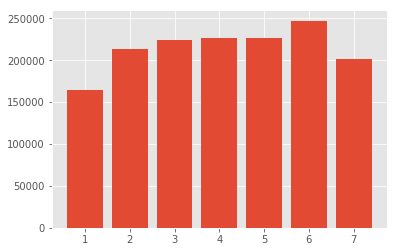

In [30]:
plt.bar(data.index, data)

#### Accident by hour of Day

<BarContainer object of 24 artists>

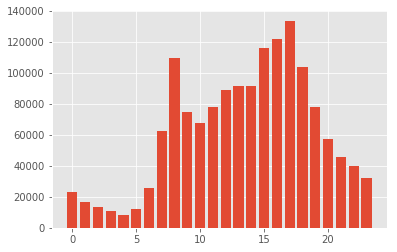

In [31]:
hour_data = df.groupby(by='Hour').size()
plt.bar(hour_data.index, hour_data)

In [32]:
df.Accident_Severity.head()

0    2
1    3
2    3
3    3
4    3
Name: Accident_Severity, dtype: uint8

<BarContainer object of 24 artists>

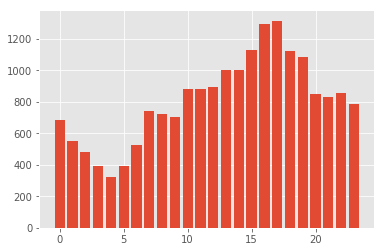

In [33]:
hour_data = df[df['Accident_Severity'] == 1].groupby(by='Hour').size()
plt.bar(hour_data.index, hour_data)

<BarContainer object of 24 artists>

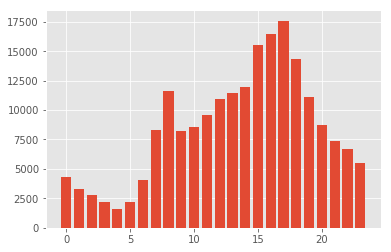

In [34]:
hour_data = df[df['Accident_Severity'] == 2].groupby(by='Hour').size()
plt.bar(hour_data.index, hour_data)

<BarContainer object of 24 artists>

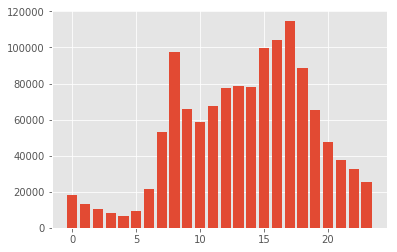

In [35]:
hour_data = df[df['Accident_Severity'] == 3].groupby(by='Hour').size()
plt.bar(hour_data.index, hour_data)

In [40]:
contingency = pd.crosstab(df['Hour'], df['Accident_Severity'], normalize='index')

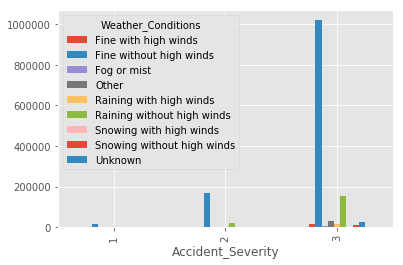

In [37]:
df.groupby(['Accident_Severity', 'Weather_Conditions']).size().unstack().plot(kind='bar')

In [87]:
df[((df.Day_of_Week == 5)&((df.Hour >= 22)|(df.Hour < 6))) | ((df.Day_of_Week == 6)&((df.Hour >= 22)|(df.Hour < 6))) | ((df.Day_of_Week == 7)&((df.Hour < 6)))  ][['Hour', 'Day_of_Week']].head(n = 15)

Hour  Day_of_Week
2     0.0            5
16    0.0            5
19    3.0            7
35   22.0            5
40   23.0            6
71    0.0            6
73    1.0            7
77    4.0            6
87    2.0            7
111  23.0            5
124  23.0            5
133   3.0            7
146  23.0            6
177   0.0            7
203  23.0            5

In [90]:
df['weekend_night']= ((df.Day_of_Week == 5)&((df.Hour >= 22)|(df.Hour < 6))) | ((df.Day_of_Week == 6)&((df.Hour >= 22)|(df.Hour < 6))) | ((df.Day_of_Week == 7)&((df.Hour < 6)))

In [91]:
df.weekend_night.size

1504150

In [105]:
accidents_by_weekendnight = df.groupby(['Accident_Severity', 'weekend_night']).size()
accidents_by_weekendnight

Accident_Severity  weekend_night
1                  False              17580
                   True                1861
2                  False             192485
                   True               12019
3                  False            1230835
                   True               49370
dtype: int64

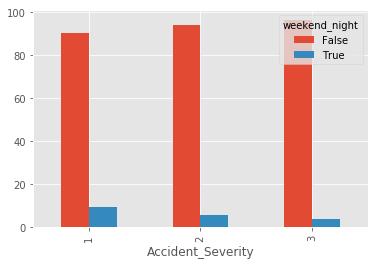

In [115]:
accidents_by_weekendnight.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).unstack().plot(kind='bar')

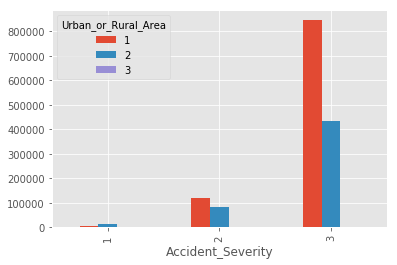

In [122]:
df.groupby(['Accident_Severity' ,'Urban_or_Rural_Area' ]).size().unstack().plot(kind='bar')

In [127]:
df.groupby(['Accident_Severity', '']).size()

ValueError: Length of passed values is 1504150, index implies 0

In [132]:
df.Junction_Control.head()

0                         NaN
1    Automatic traffic signal
2                         NaN
3                         NaN
4                         NaN
Name: Junction_Control, dtype: category
Categories (4, object): [Authorised person, Automatic traffic signal, Giveway or uncontrolled, Stop Sign]

In [158]:
piv = pd.pivot_table(df[df.Accident_Severity == 1], values='Accident_Severity', index=["Hour"], columns=["Day_of_Week"], aggfunc='size',fill_value=0)

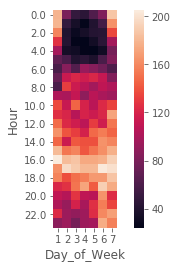

In [159]:
ax = sns.heatmap(piv, square=True)

In [42]:
from scipy.stats import chi2_contingency

In [46]:
chi2_contingency(contingency)

(0.31247509262131556, 1.0, 46, array([[0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
        [0.01848607, 0.15134402, 0.83016991],
    

In [47]:
contingency_1 = pd.crosstab(df['Hour'], df['Accident_Severity'])

In [48]:
contingency_1

Accident_Severity     1      2       3
Hour                                  
0.0                 684   4341   18000
1.0                 550   3272   13068
2.0                 483   2768   10367
3.0                 392   2175    8260
4.0                 324   1627    6396
5.0                 393   2203    9439
6.0                 523   4048   21261
7.0                 741   8282   53351
8.0                 722  11638   97262
9.0                 705   8259   65937
10.0                880   8527   58488
11.0                882   9615   67638
12.0                896  10939   77390
13.0               1004  11463   78895
14.0               1005  11987   78270
15.0               1127  15566   99573
16.0               1291  16452  104388
17.0               1315  17589  114835
18.0               1122  14328   88635
19.0               1082  11147   65499
20.0                849   8771   47596
21.0                829   7334   37586
22.0                857   6683   32351
23.0                784   5470   25624

In [49]:
chi2_contingency(contingency_1)

(10188.313952183866,
 0.0,
 46,
 array([[2.97603842e+02, 3.13041276e+03, 1.95969834e+04],
        [2.18307444e+02, 2.29631581e+03, 1.43753767e+04],
        [1.76016032e+02, 1.85146410e+03, 1.15905199e+04],
        [1.39941664e+02, 1.47200777e+03, 9.21505056e+03],
        [1.07887048e+02, 1.13483411e+03, 7.10427884e+03],
        [1.55555363e+02, 1.63624398e+03, 1.02432007e+04],
        [3.33885014e+02, 3.51204441e+03, 2.19860706e+04],
        [8.06199438e+02, 8.48018961e+03, 5.30876110e+04],
        [1.41689157e+03, 1.49038918e+04, 9.33012167e+04],
        [9.68114024e+02, 1.01833245e+04, 6.37495615e+04],
        [8.77559734e+02, 9.23080889e+03, 5.77866314e+04],
        [1.00991428e+03, 1.06230098e+04, 6.65020759e+04],
        [1.15325528e+03, 1.21307743e+04, 7.59409704e+04],
        [1.18087654e+03, 1.24213147e+04, 7.77598088e+04],
        [1.17958401e+03, 1.24077190e+04, 7.76746970e+04],
        [1.50276692e+03, 1.58071909e+04, 9.89560422e+04],
        [1.57857350e+03, 1.66045794e+04,